# Imports

In [2]:
#Importing the libraries
import copy
import itertools
import math
import numpy as np
import pandas as pd
import random
import scipy
import scipy.cluster.hierarchy as sch
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap
from pandas import DataFrame

from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

sns.set(style="whitegrid")


In [3]:
#Peak Areas for all peaks in all samples (450x514)
dfPeakAreas = pd.read_csv("finrisk-peak-areas_450peaks.tsv", sep="\t", index_col = 0)

#m/z, runtime and ion mode (positive (1) or negative (-1)) for all peaks
dfPeakList =  pd.read_csv("finrisk-peak-list_450peaks.tsv", sep="\t", index_col = 0, header = None)

#QC peak areas for all peaks in all brackets (450x27) (only positive ion mode available)
dfQCPeaks = pd.read_csv("finrisk-QC-peak-areas_450peaks.tsv",sep="\t", index_col = 0)

#peak areas for all peaks, without overlaps - 47 peaks excluded from dfPeakAreas(403x514)
#dfPANOL = dfPeakAreasNoOverlaps
dfPANOL = pd.read_excel("dfPeakAreasNoOL.xlsx", sep="\t", index_col = 0)

#Information from HMDB, positive mode (dfHMDBPos) and negative mode (dfHMDBNeg)
dfHMDBPos = pd.read_excel("Pos_MultiplexLabeledHMEC_PeakList_notes_RN.xlsx", sep="\t", index_col = 0)
dfHMDBNeg = pd.read_excel("Neg_MultiplexLabeledHMEC_PeakList_notes_RN.xlsx", sep="\t", index_col = 0)

#Information from MIDs for all peaks from HMEC (897 x 403)
dfMIDs = pd.read_excel("MIDs.xlsx", sep = "\t", index_col = 0)

#Information of peaks disease associations
dfDisease = pd.read_excel(r"Z:\Private\disease-associations\hmec-multiplex-all-assoc.xlsx", sep = "\t", index_col=0)

#Runtimes for when the plates was analyzed
runtimes = pd.read_csv("runtimes.tsv", sep="\t", index_col=0)
#Dropping one runtime axis, one is enough to check for batch effects
runtimes.drop('Run time neg', axis = 1, inplace=True)

# Deleting 0-rows in QC-peaks - those without measured values

In [4]:
#Makes a list of indexes where mean == 0 in dfQCPeaks
indexes =[]
for i in range(len(dfQCPeaks.index)):
    if dfQCPeaks.iloc[i].mean() == 0:
        indexes.append(dfQCPeaks.iloc[i].name)
        
#Drop the rows where mean == 0
counter = 0 #counter for checking how many we dropped
for j in range(len(indexes)):
    dfQCPeaks.drop(index = indexes[j], inplace = True)
    counter += 1

# Module 1: Get all DataFrames:

## Get dfPANOLNo0 and dfQCPeaksNo0
### replacing values with ffill (or bfill if first value was 0). Used for calculating biovariance

In [5]:
def getNo0DFs(dfPANOL, dfQCPeaks):
    dfPANOLNo0 = dfPANOL.copy(deep = True)
    dfQCPeaksNo0 = dfQCPeaks.copy(deep = True)

    for i in range(len(dfPANOLNo0.index)):
        name = dfPANOLNo0.index[i]

        value = dfPANOLNo0.loc[name].replace(to_replace = 0, method='ffill')
        value = value.replace(to_replace = 0, method = 'bfill')

        dfPANOLNo0.loc[name] = value    

    for j in range(len(dfQCPeaksNo0.index)):
        name2 = dfQCPeaksNo0.index[j]

        value2 = dfQCPeaksNo0.loc[name2].replace(to_replace = 0, method = 'ffill')
        value2 = value2.replace(to_replace = 0, method = 'bfill')

        dfQCPeaksNo0.loc[name2] = value2
    
    return dfPANOLNo0, dfQCPeaksNo0

## Calculating biovariance

***Assuming a log-normal distribution where lnX=Normal and a multiplicate noise-model X = Y*Z, where X = peak areas in dfPANOL and Z = peak areas in QCPeaks, we get ln(X) = ln(Y) + ln(Z). We use that the variance is additative: VAR(ln(X)) = VAR(ln(Y)) + VAR(ln(Z)) --> VAR(ln(Y)) = Var(ln(X)) - VAR(ln(Z))**

**Creating logDataFrames, using the dataframes without 0-values**

**We assume that we have a log-normal distribution, thus we want to take the log of it to get the normal distribution:
if X is log-distributed, ln(X) is normally disitributed**

In [6]:
def getAllBioVariance(dfPANOL, dfQCPeaks, dfPANOLNo0, dfQCPeaksNo0):
    
    #Take the log of the values, to get a normal distribution
    logdfQCPeaks= np.log(dfQCPeaksNo0)
    logdfPANOL = np.log(dfPANOLNo0)
    
    #Now we have ln(X) and ln(Z)-values, thus having normal distributions
    
    #DF of ln(QCPeaks) with std, mean, count etc
    tranDescribeQCln = logdfQCPeaks.transpose().describe()
    #DF of ln(PANOL) with std, mean, count etc
    tranDescribeMetsln = logdfPANOL.transpose().describe()
    
    
    #Now we delete peaks that are in QC but not in Mets (because of overlap) and those that are in Mets but not in QC 
    #(because of 0-rows, only positive ion-mode is there so all negative ion modes is 0):
    qcNames = tranDescribeQCln.columns
    metNames = tranDescribeMetsln.columns

    toDelete = list((set(metNames) - set(qcNames)))

    for i in range(len(toDelete)):
        tranDescribeMetsln.drop(columns = toDelete[i], inplace = True)

    toDelete = list((set(qcNames) - set(metNames)))
    for i in range(len(toDelete)):
        tranDescribeQCln.drop(columns = toDelete[i], inplace = True)
    
    #Now we calculate variances for ln(Observed) and ln(QC - QCmean)
    #We can use a normal variance formula, since we have normal distribution (logged values of log-normal distribution)
    #Create two lists for the variances in QC and Observed values
    varilnQC = []
    varilnObs = []
    meanlnQC = []
    meanlnObs = []
    for i in range(len(tranDescribeMetsln.columns)):
        varilnQC += [[tranDescribeQCln.columns[i], (tranDescribeQCln.iloc[2,i]**2)]] #tranDescribe.iloc[2,i] = std of column i
        meanlnQC += [[tranDescribeQCln.columns[i], (tranDescribeQCln.iloc[1,i])]] #tranDescribe.iloc[1,i] = mean of column i
        
        varilnObs += [[tranDescribeMetsln.columns[i], (tranDescribeMetsln.iloc[2,i]**2)]]
        meanlnObs += [[tranDescribeMetsln.columns[i], (tranDescribeMetsln.iloc[1,i])]]
    
    #sorts alfphabetically, extra check that both lists comes in the same order
    sorted(varilnObs)
    sorted(varilnQC)
    
    #We assume that the mean(QC) = 1, otherwise we would have seen a much higher boost in X = Y*Z. So mean(Y) = mean(X)
    #The variance of ln(Y) is ln(X) - ln(Z).
    
    #Calculating VAR(ln(biological)) (ln(Y))
    varilnBio = [] #=VAR(ln(Y))
    for i in range(len(varilnQC)):
        varianceLnBio = (varilnObs[i][1] - varilnQC[i][1])
        varilnBio += [[varilnQC[i][0], varianceLnBio]]
    sorted(varilnBio)
    
    #Converting the mean and the variance back to log-normal values, getting mean(biological) and VAR(biological)
    #Converting from a normal distribution to a log-normal distribution is:
    #mean(Y) = exp(mean(ln(Y))+(variance(lnY)/2))
    #variance(Y) = (exp(variance(ln(Y))-1)(exp(2*mean + variance))
    
    #Calculating the biological variance for log-normal distribution
    variBio = []
    for i in range(len(varilnBio)):
        name = varilnBio[i][0]
        lnVariance = varilnBio[i][1] #the variance of ln(Y)
        lnMean = tranDescribeMetsln[name][1] #the mean of ln(Y) = mean of ln(X)
        meanBio = math.exp(lnMean + (lnVariance/2)) #Following the formula for log-normal means
        
        varianceBio = (math.exp(lnVariance)-1)
        
        variBio += [[name, varianceBio]]
    
    sorted(variBio)
    
    return variBio, varilnBio, varilnObs, varilnQC, meanlnObs, meanlnQC

## Calculating CV-Bio and CV-QC

In [7]:
def calculateCvBioAndQC(varilnBio, varilnObs, varilnQC):
    cvBio = []
    cvQC = []
    cvObs = []

    

    for i in range(len(varilnBio)):
        valueQC = (math.exp(varilnQC[i][1]))-1
        valueObs = (math.exp(varilnObs[i][1]))-1
        valueBio = (math.exp(varilnBio[i][1])) - 1
        
        if valueBio > 0:
            cvBio += [[varilnBio[i][0], math.sqrt(valueBio)]]
        if valueQC > 0:
            cvQC += [[varilnQC[i][0], math.sqrt(valueQC)]]
        if valueObs > 0:
            cvObs += [[varilnObs[i][0], math.sqrt(valueObs)]]

    cvBio.sort()
    cvQC.sort()
    cvObs.sort()
    
    return cvBio, cvQC, cvObs

## Create dictionary of HMDB-annotations

In [8]:
def getHMDBDicPosAndNeg (dfHMDBPos, dfHMDBNeg):
    dfHMDBPos.fillna(0, inplace = True)
    dfHMDBNeg.fillna(0, inplace = True)

    keys = []
    values = []
    for i in range(len(dfHMDBPos.index)):
        if dfHMDBPos.iloc[i,-4] != 0:
            keys += [str(dfHMDBPos.index[i])]
            values += [dfHMDBPos.iloc[i,-4]]

    dicPos = dict(zip(keys,values))


    keys = []
    values = []
    for i in range(len(dfHMDBNeg.index)):
        if dfHMDBNeg.iloc[i,-4] != 0:
            keys += [str(dfHMDBNeg.index[i])]
            values += [dfHMDBNeg.iloc[i,-4]]

    dicNeg = dict(zip(keys,values))
    
    return dicPos, dicNeg

## Creating dfAnnot

In [9]:
#Combine the two dictionaries
def getdfAnnot(dicPos, dicNeg):
    z = {**dicPos, **dicNeg} 
    dfAnnot = pd.DataFrame(z.keys())
    dfAnnot.set_index(0, inplace = True)
    dfAnnot['HMDB-Annot'] = np.nan

    for i in range(len(dfAnnot.index)):
        dfAnnot.iloc[i,0] = z[dfAnnot.iloc[i].name]
    
    return dfAnnot, z


## Get dfCV, dataframe containing CV's with peaks where we have all 3 (positive cvBio, QC-data and Obs)

In [10]:
def getdfCV(cvBio, cvQC, cvObs):
    #Some peaks doesn't exists in cvBio that exists in cvQC, since these had negative bio-variance
    #Some peaks doesn't exists in cvQC that exists in cvBio, since these had a variance of 0 of the QC-values
    bioAndQCmets = []
    for i in range(len(cvBio)):
        for j in range(len(cvQC)):
            if cvBio[i][0] == cvQC[j][0]:
                bioAndQCmets += [cvBio[i][0]]
    
    valuesBio = []
    valuesQC = []
    valuesObs = []

    cvPeakNames = []
    
    #Extract the values in the order of bioAndQCmets:
    for i in range(len(cvBio)):
        for j in range(len(bioAndQCmets)):
            if bioAndQCmets[j] == cvBio[i][0]:
                valuesBio += [cvBio[i][1]]
                cvPeakNames += [cvBio[i][0]]


    for i in range(len(cvQC)):
        for j in range(len(bioAndQCmets)):
            if bioAndQCmets[j] == cvQC[i][0]:
                valuesQC += [cvQC[i][1]]

    for i in range(len(cvObs)):
        for j in range(len(bioAndQCmets)):
            if bioAndQCmets[j] == cvObs[i][0]:
                valuesObs += [cvObs[i][1]]
                
                
    #Create df
    dfCV = pd.DataFrame({'Peaks':cvPeakNames, 'cvBio': valuesBio, 'cvQC': valuesQC, 'cvObs':valuesObs})
    
    dfCV.set_index('Peaks', inplace = True)
    
    #Rename indexes, with annotations:
    for i in range(len(dfCV.index)):
        try:
            dfCV.rename({dfCV.index[i]: z[dfCV.index[i][5:]]}, inplace = True)
        except KeyError:
            continue

    
    return dfCV               
    

## Create normalized dataframe dfPANOLMin

In [11]:
def getdfPANOLMin(dfPANOL):
    dfPANOLMin = dfPANOL.copy(deep = True)
    
    #Finding the minimum value in each row (minimum peak intensity for each peak)
    mini = 987127839182739817239817
    for i in range(len(dfPANOLMin.index)):
        for j in range(len(dfPANOLMin.columns)):
            value = dfPANOLMin.iloc[i,j]
            if value != 0:
                if mini > value:
                    mini = value
        
        #Setting 0-values to the minimum value obtained from above
        for k in range(len(dfPANOLMin.columns)):
            if dfPANOLMin.iloc[i,k] == 0:
                dfPANOLMin.iloc[i,k] = mini
        mini = 987127839182739817239817
    
    #Normalizing dataframe through division-by-mean
    for i in range(len(dfPANOLMin.index)):
        meanValue = dfPANOLMin.iloc[i,:].mean()
        for j in range(len(dfPANOLMin.columns)):
            dfPANOLMin.iloc[i,j] = dfPANOLMin.iloc[i,j]/meanValue
        
    aight = 0
    #Setting outliers to = 4
    for i in range(len(dfPANOLMin.index)):
        for j in range(len(dfPANOLMin.columns)):
            if dfPANOLMin.iloc[i,j] > 4:
                aight += 1
                dfPANOLMin.iloc[i,j] = 4.0
    
    print('dfPANOLMin outliers-count:' + str(aight))
    
    return dfPANOLMin

## Creating dfPANOLWA

In [12]:
def getdfPANOLWA(dfPANOL):
    
    dfPANOLWA = dfPANOL.copy(deep = True)
    
    for i in range(len(dicPos)):
        for j in range(len(dfPANOLWA.index)):
            try:
                dfPANOLWA.rename(index = {dfPANOLWA.index[j]: dicPos[dfPANOLWA.index[j][5:]]}, inplace = True)
            except KeyError:
                continue

    for i in range(len(dicNeg)):
        for j in range(len(dfPANOLWA.index)):
            try:
                dfPANOLWA.rename(index = {dfPANOLWA.index[j]: dicNeg[dfPANOLWA.index[j][5:]]}, inplace = True)
            except KeyError:
                continue
                
    
    return dfPANOLWA

# Get all the computed lists and DataFrames from here

In [13]:
dfPANOLNo0, dfQCPeaksNo0 = getNo0DFs(dfPANOL, dfQCPeaks)

#Get all BioVariance:
variBio, varilnBio, varilnObs, varilnQC, meanlnObs, meanlnQC = getAllBioVariance(dfPANOL, dfQCPeaks, dfPANOLNo0, dfQCPeaksNo0)

 #Get cvBio:
cvBio, cvQC, cvObs = calculateCvBioAndQC(varilnBio, varilnObs, varilnQC)


#Creates two dictionaries with annotations from positive ion mode (dicPos) and negative ion mode (dicNeg)
dicPos, dicNeg = getHMDBDicPosAndNeg (dfHMDBPos, dfHMDBNeg)

#Create dfAnnot, dataframe for all annotations from HMDB we have,
 #by combining dicPos and dicNeg in a dataframe. z is a merged dic of dicPos and dicNeg.
dfAnnot, z = getdfAnnot(dicPos, dicNeg)

#the lengths of cvBio, cvQC and cvOBS are different (we have QC's for some, some are negative cvBio etc)
#Here we get a dataframe of the peaks where we have values for all 3 (bio (only positives), QC and Obs)
dfCV = getdfCV(cvBio, cvQC, cvObs)

 
 #creates dfPANOLMin - normalized dataframe
dfPANOLMin = getdfPANOLMin(dfPANOL)

 

 #Create dfPANOLWA, dfPANOL With Annotations
dfPANOLWA = getdfPANOLWA(dfPANOL)



dfPANOLMin outliers-count:1158


**///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# Module 2: Sort and plot dfCV, here with only known annotations

In [13]:
dfCV.sort_values('cvBio', ascending = True, inplace = True) #Switch ascending True/False for lowest/highest cvBio

In [14]:
counter = 0
ind = []
for i in range(len(dfCV.index)):
    if 'potLm' not in dfCV.index[i]:
        counter += 1
        ind += [i]
    if counter == 15: #increase/decrease for bigger df
        break

In [15]:
dfCV.loc[dfCV.index[ind]]

,cvBio,cvQC,cvObs
Peaks,,,
methyladenosine,0.081220,0.075191,0.110850
tryptophan,0.093282,0.164025,0.189314
methionine,0.102585,0.144193,0.177578
phenylalanine,0.126416,0.120638,0.175406
tyrosine,0.168201,0.150224,0.226930
threonine,0.176329,0.142028,0.227796
serine,0.181567,0.087501,0.202177
isoleucine,0.190720,0.134401,0.234723
alanine,0.195680,0.104936,0.222989


**Searching for Obsereved Values where QC were not available (cvOBS only for those with QC)**

In [56]:
search = np.log(dfPANOLNo0)
search2 = search.transpose().describe()
value = search2['potLm4661'][2]**2

math.sqrt(math.exp(value)-1)

0.37506769680487095

**///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# Module 3: Clustering peaks and samples

### Clustering peaks

**Create distance-matrix and linkage for metric: correlation and method: average, using the normalized dataframe dfPANOLMin**

In [16]:
dr = sch.distance.pdist(dfPANOLMin, metric = 'correlation') #Change to dfCluster for debug
Lrows = sch.linkage(dr, method = 'average')

dc = sch.distance.pdist(dfPANOLMin.transpose(), metric = 'correlation')
Lcol = sch.linkage(dc, method = 'average')


In [17]:
arrayCol = []
arrayRow = []

for i in range(len(dfPANOLWA.columns)): #dfPANOLWA, dfPANOLMin without annotations
    arrayCol += [dfPANOLWA.columns[i]]

for j in range(len(dfPANOLWA.index)): #dfPANOLWA, dfPANOLMin without annotations
    arrayRow += [dfPANOLWA.index[j]]

**Getting the clustermap (Figure 2 in report)**

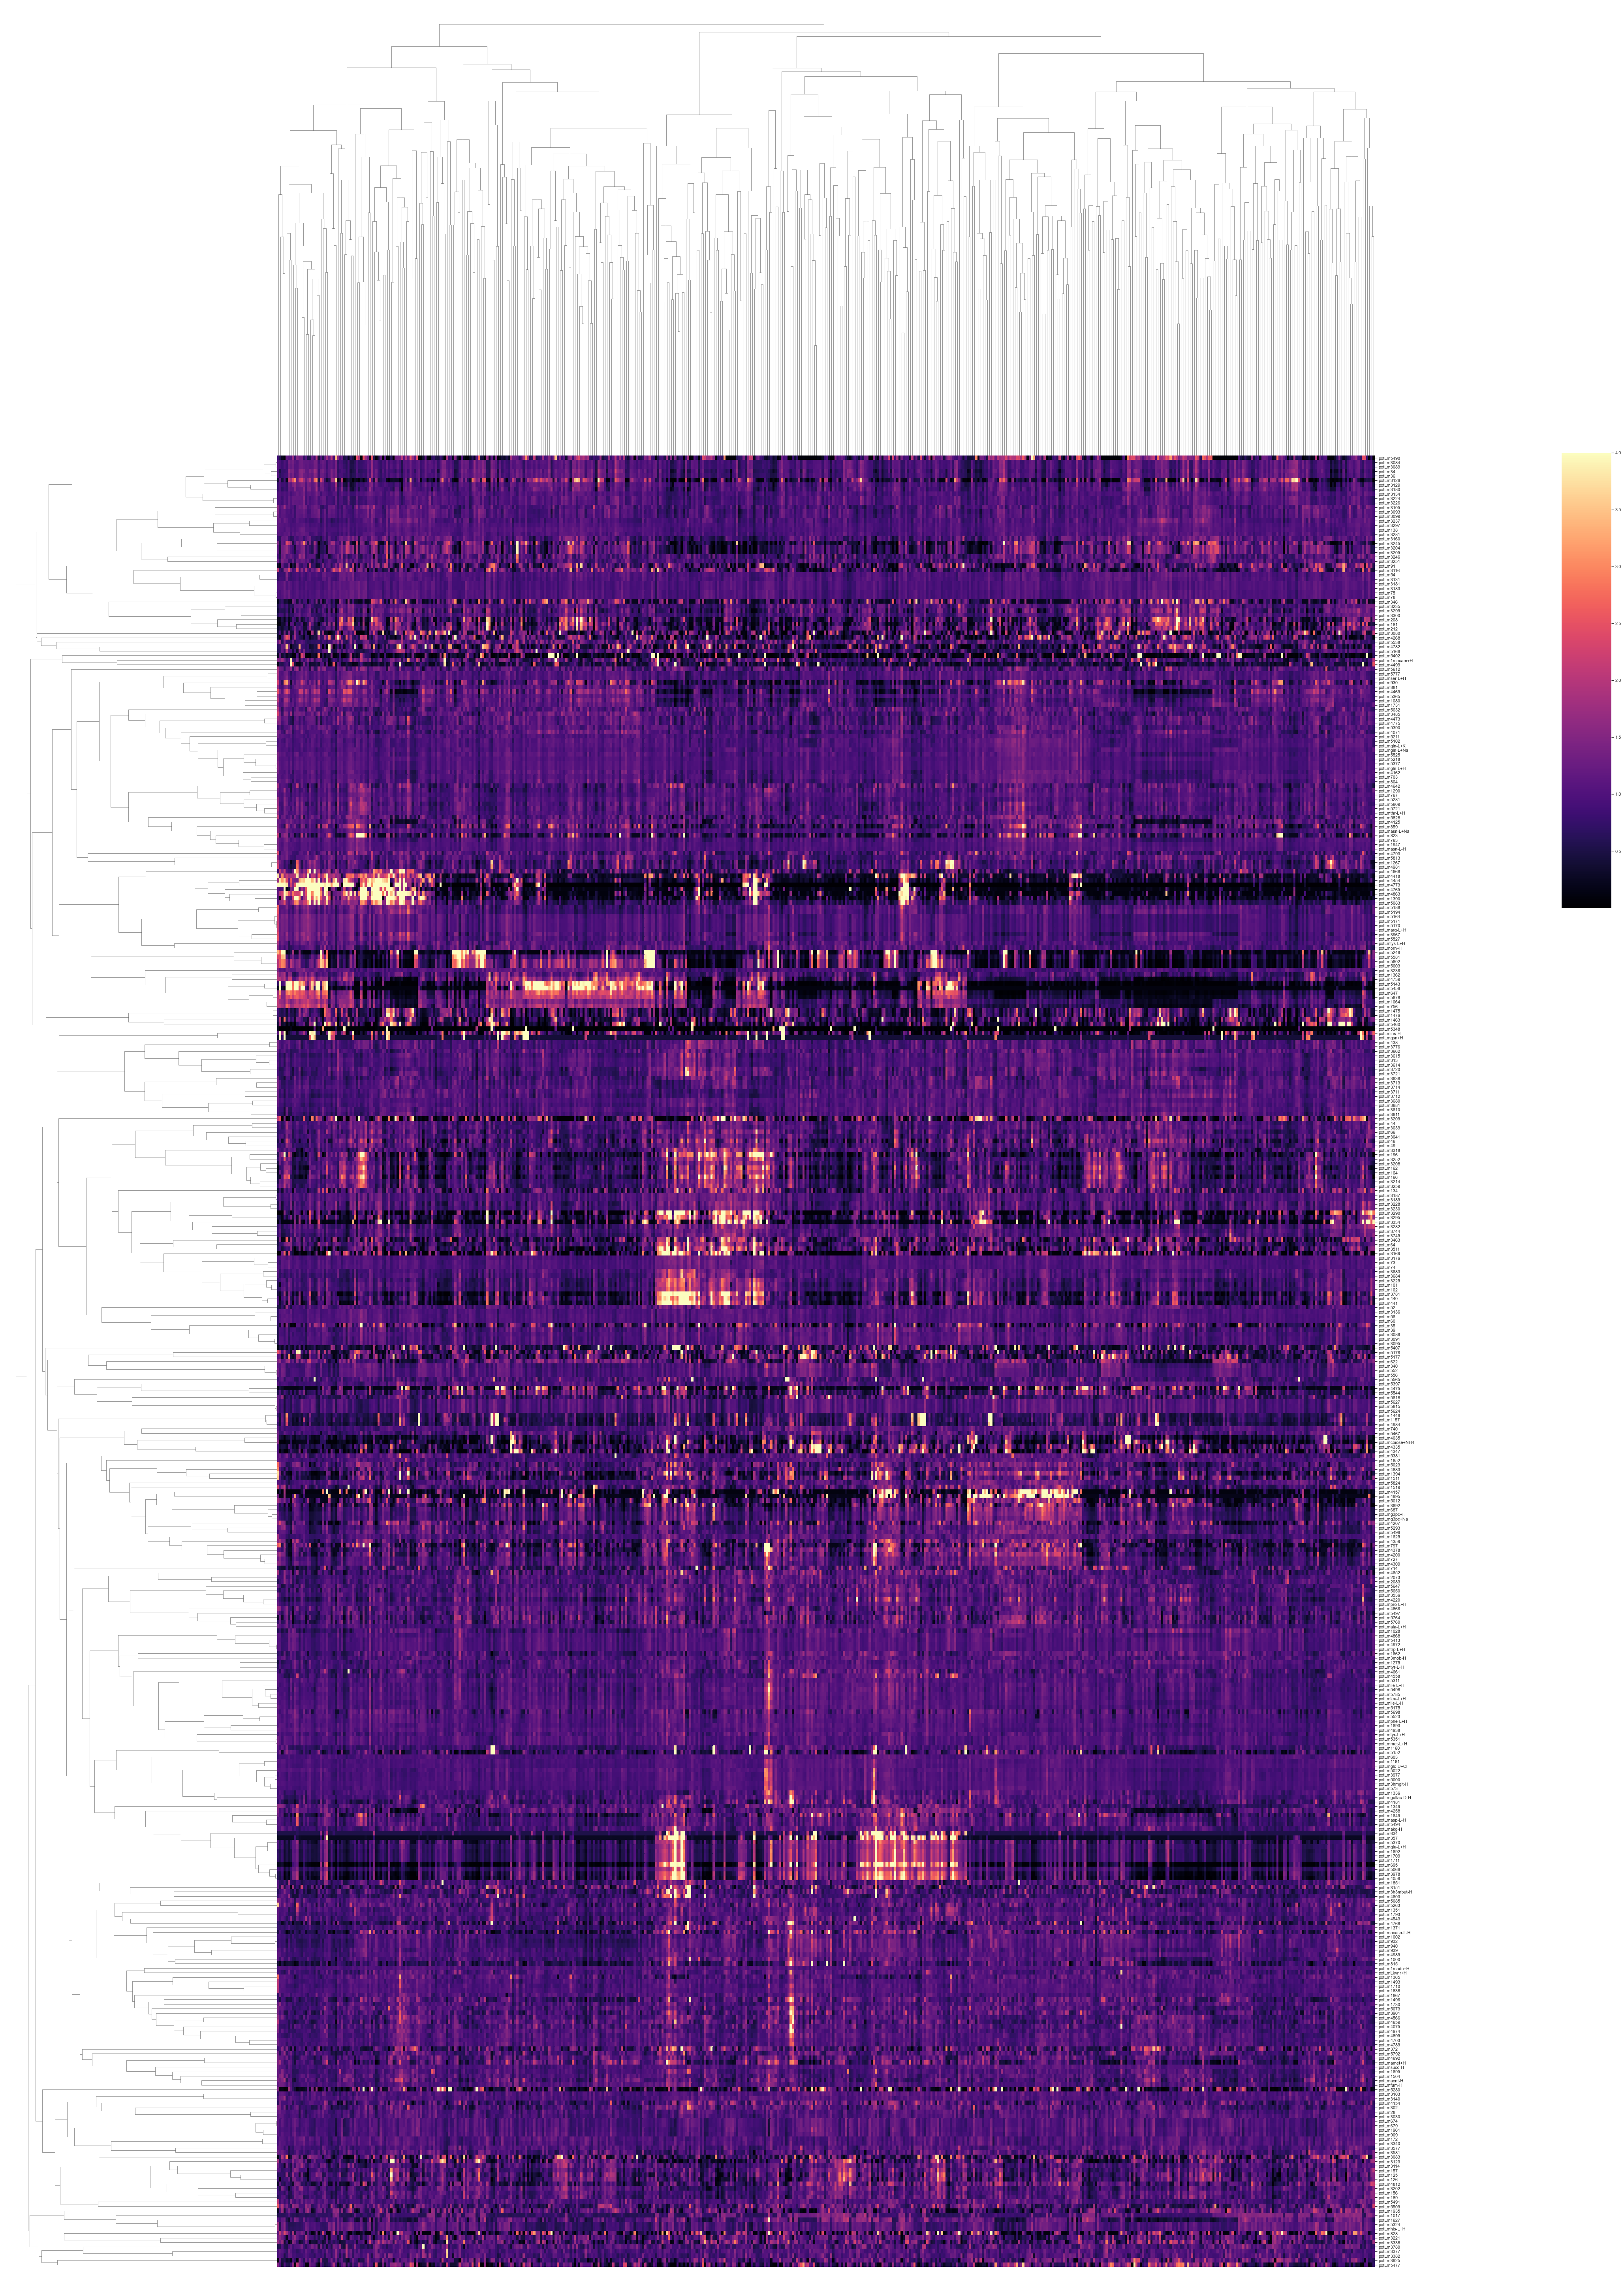

In [18]:

sclusterfig = sns.clustermap(dfPANOLMin, figsize = (50,80), col_linkage = Lcol, row_linkage = Lrows, 
                             cmap = 'magma', cbar_pos=(1.1,0.6,0.035,0.2), xticklabels = False, yticklabels = True)

# plt.figure(figsize=(10,10))
# ax = sns.heatmap(dfPANOLMin, cmap = 'magma')
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=30)
# #plt.show()
# fig = ax.get_figure()
# fig.savefig('cbar3')
# #cbar = sclusterfig.collections[0].colorbar
# #cbar.ax.tick_params(labelsize=20)

#sclusterfig.savefig('clusterMap.pdf')

**Get dendrogram for clustered peaks (Used for figure 3 in report)**

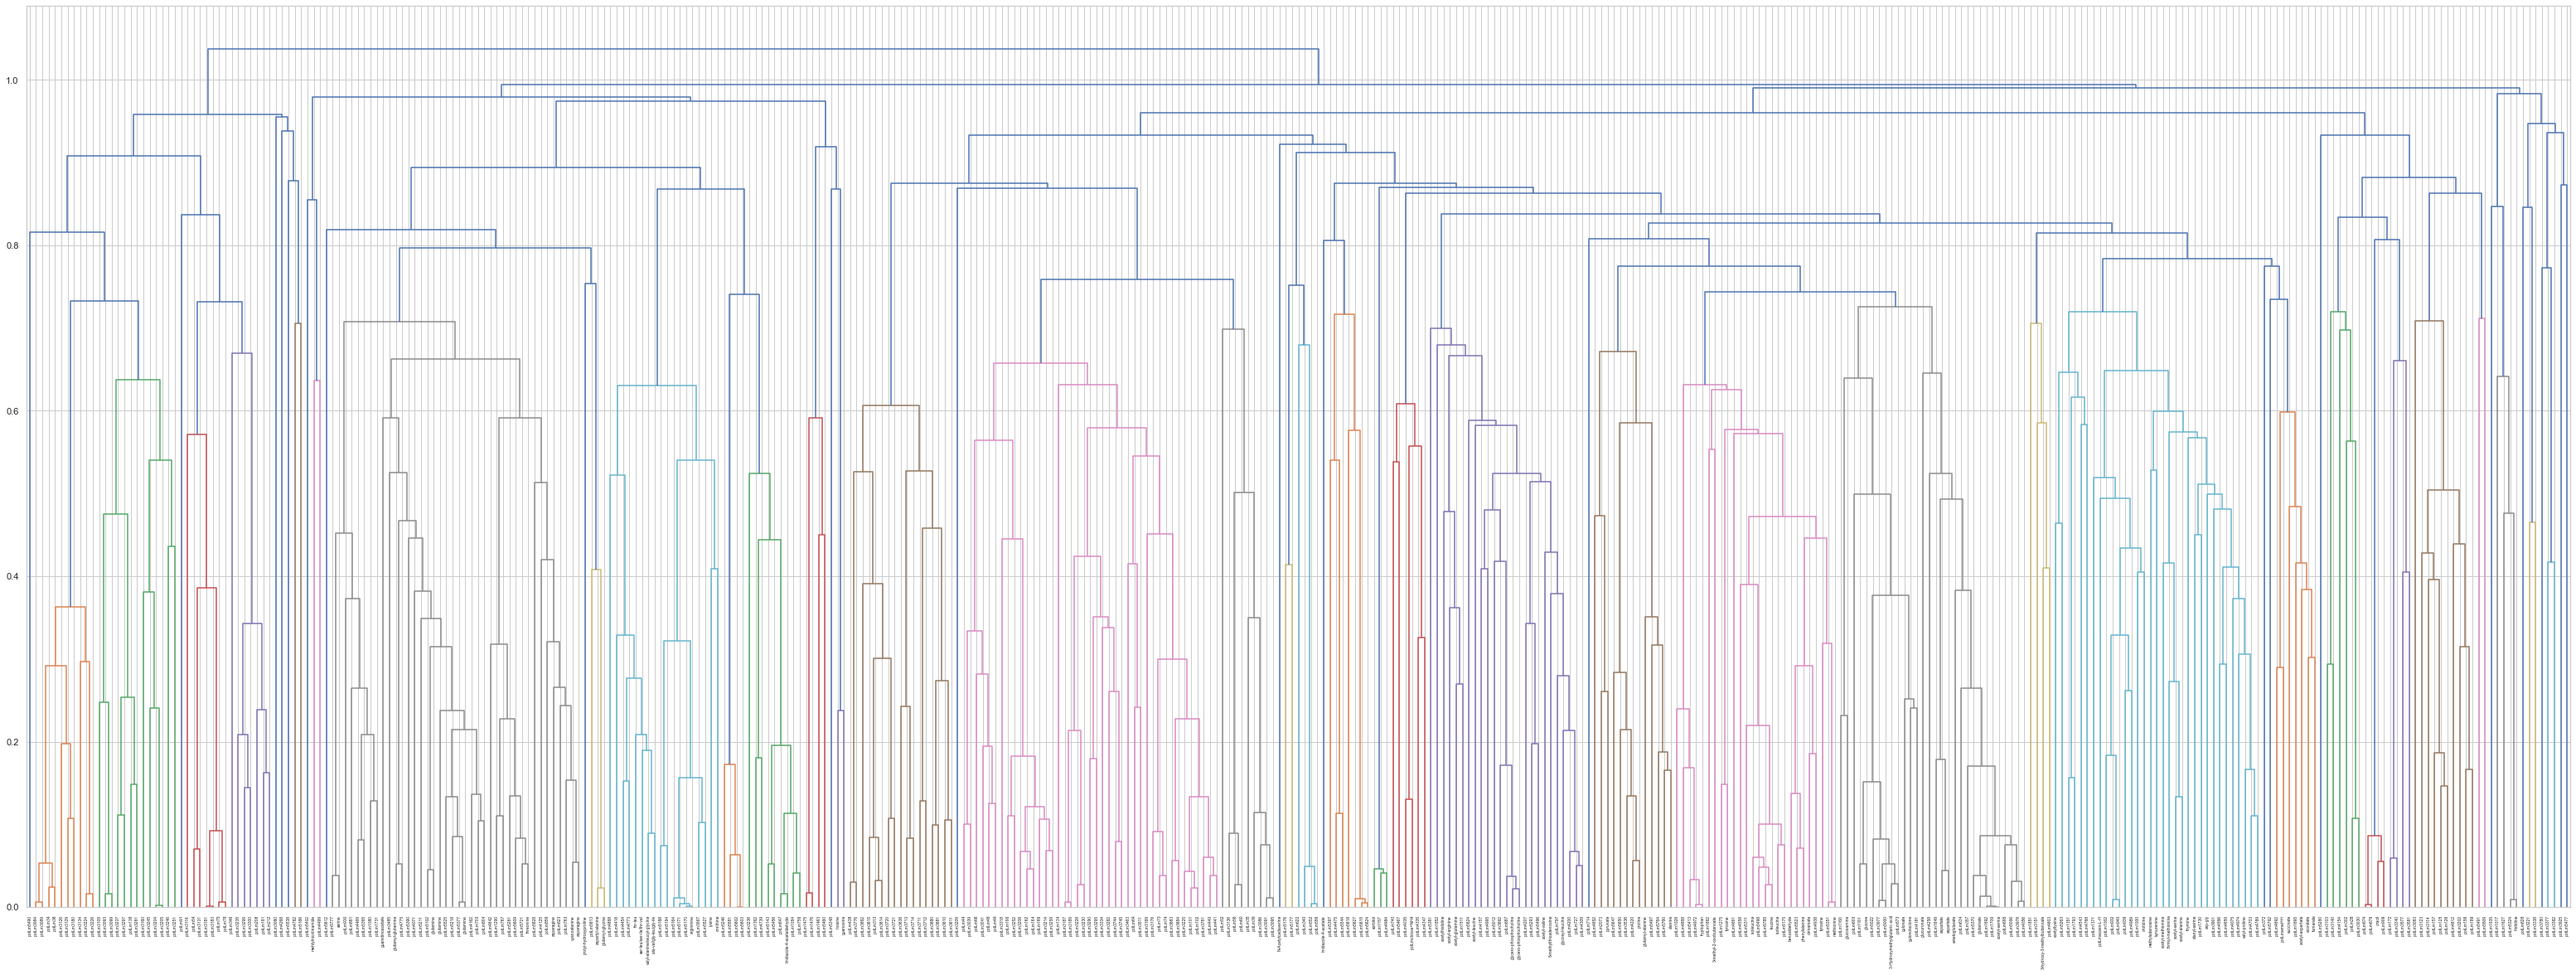

In [19]:
plt.figure(figsize = (55,20))
dend = sch.dendrogram(Lrows, labels = arrayRow)
#plt.savefig('dendro_AllMets.pdf', dpi = 200)

### Checking for batch effects: Clustering the samples.
**For coloring the plate according to their respective batches, used in dendrogram when visualizing batch effects (clustering plates to see if they end up clustering with plates from the same batch)**

In [20]:
batches = []
for i in range(len(arrayCol)):
    if 'Plate1' in arrayCol[i]:
        batches += ['1']
        
    elif 'Plate2' in arrayCol[i]:
        batches += ['2']
    
    elif 'Plate3' in arrayCol[i]:
        batches += ['3']
    
    elif 'Plate4' in arrayCol[i]:
        batches += ['4']
    
    elif 'Plate5' in arrayCol[i]:
        batches += ['5']
        
    elif 'Plate6' in arrayCol[i]:
        batches += ['6']
    
    
        

**Get dendrogram from clustering samples (figure 7 in report)** 

In [21]:
labeled = []
for i in range(len(arrayRow)):
    if 'potLm' not in arrayRow[i]:
        labeled += [arrayRow[i]]
    else:
        labeled += [arrayRow[i][5:]]

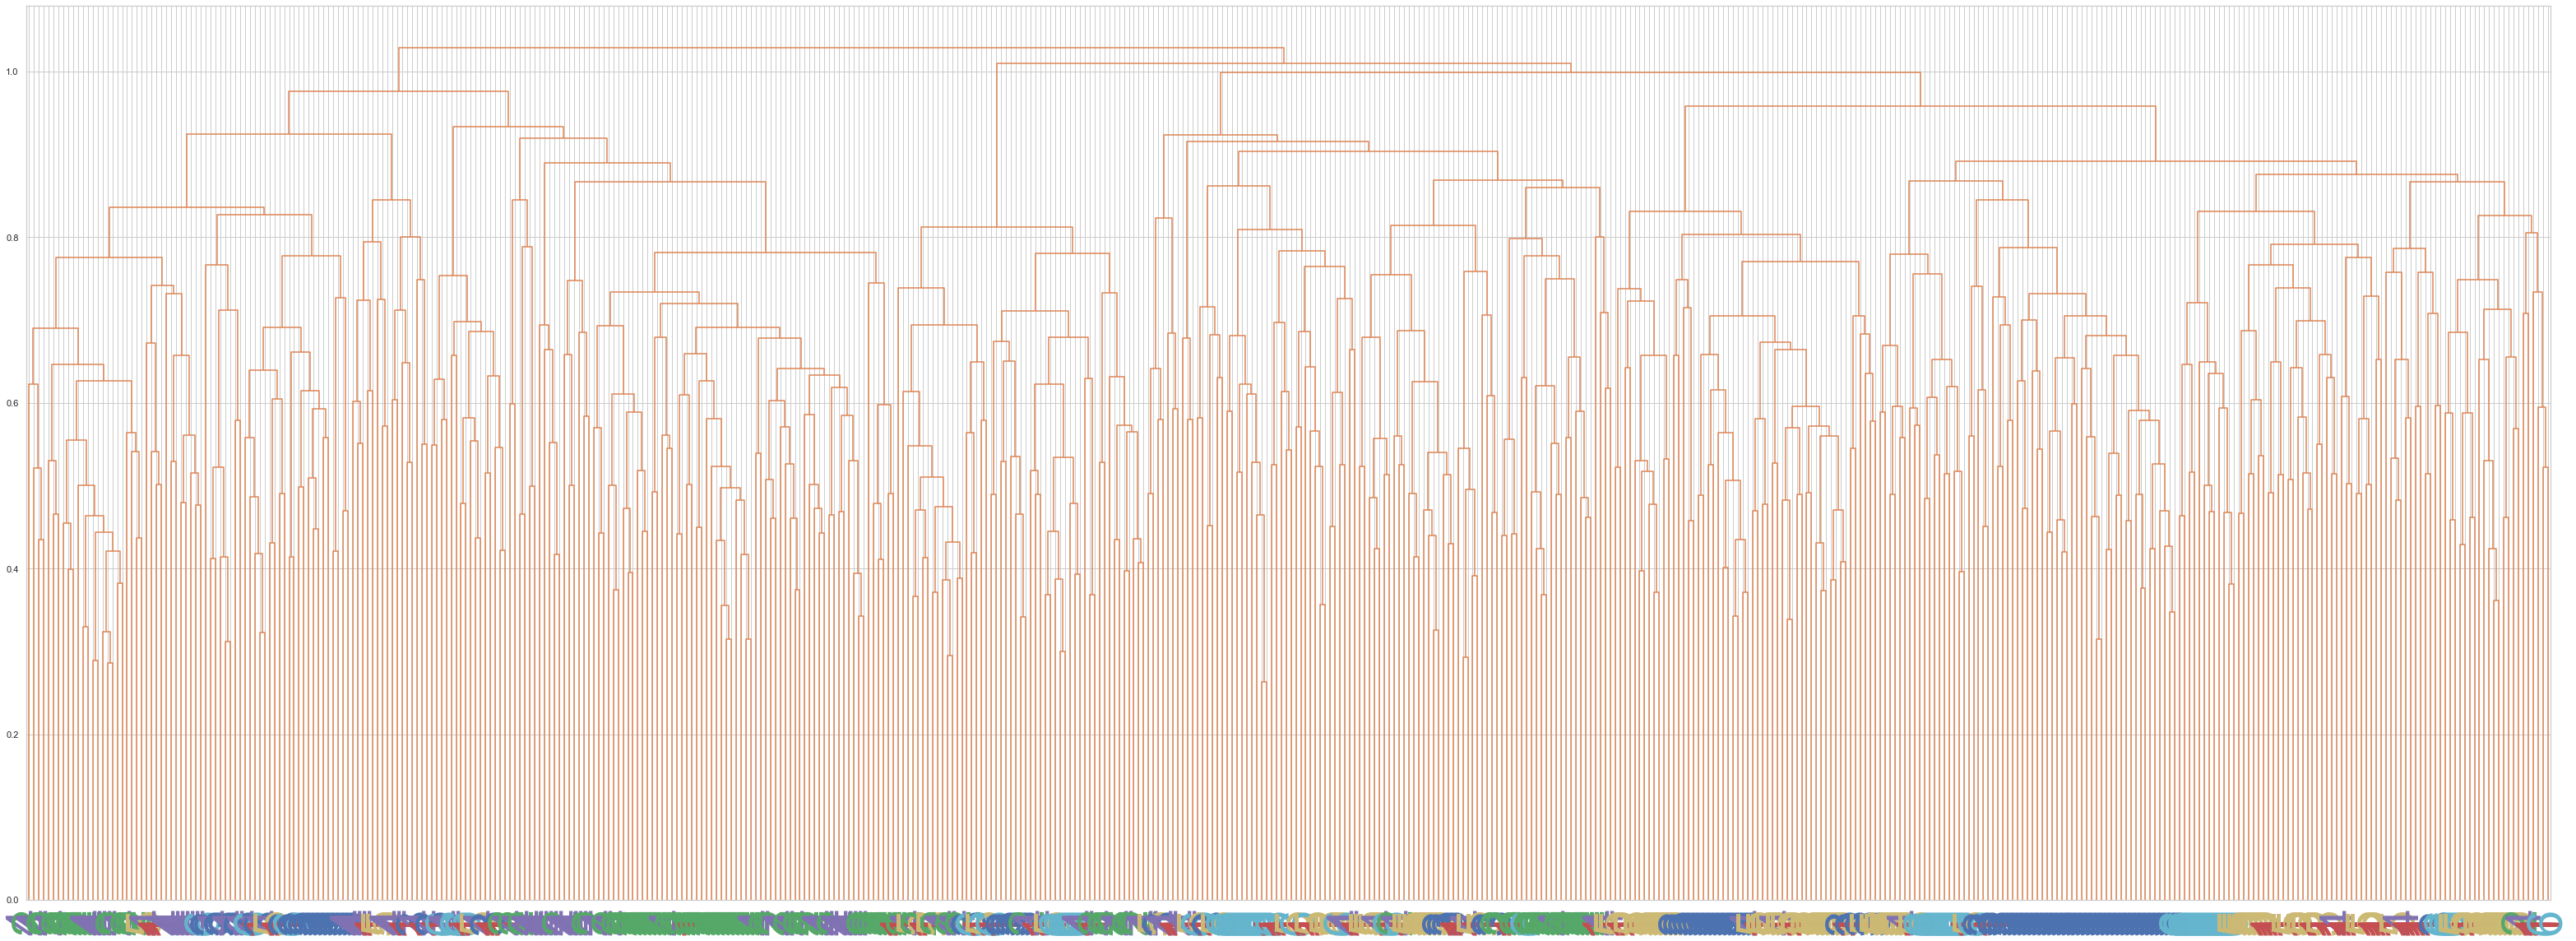

In [22]:
plt.figure(figsize = (55,20))
#Change to Lrows when clustering peaks
#Remove labels = arrayRow or arrayCols if you want peak/platename
dend = sch.dendrogram(Lcol, labels = batches, leaf_font_size = 60, color_threshold = 240)

label_colors = {'1': 'r', '2': 'g', '3': 'b', '4': 'm', '5':'y', '6':'c'}

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

#plt.savefig('dendroSamples.pdf')

**Extract list of peaks in clustered order - with information from HMDB:**

In [23]:
toList = []
for i in range(len(dfHMDBPos.index)):
    toList.append([dfHMDBPos.index[i], dfHMDBPos['DESC'].iloc[i]])

for j in range(len(dfHMDBNeg.index)):
    toList.append([dfHMDBNeg.index[j], dfHMDBNeg['DESC'].iloc[j]])

#---------------------------------------------------------------------

annotCluster = []
for i in range(len(dend['ivl'])):
    for j in range(len(toList)):
        if dend['ivl'][i][5:] == str(toList[j][0]):
            annotCluster += [toList[j][1]]
            
#---------------------------------------------------------------------

#with open("annotClusters2.txt", "w") as txt_file:
 #   for line in annotCluster:
  #      txt_file.write("".join(line) + "\n")

# Module 4: Extracting clusters
**Extract peaks into x clusters (0.6 gives x = 91)**

In [24]:
fl = fcluster(Lrows, 0.6, criterion='distance')
fl

array([66, 66, 33, 84, 33, 53, 26, 17, 44, 56, 57, 78, 78, 20, 55, 19, 57,
       34, 59, 64, 26, 67, 66,  2, 23, 47, 44, 27, 27, 27, 67, 67, 68, 47,
       48, 78, 78, 32, 48, 83, 32, 58, 32, 54, 58, 55, 68, 58, 67, 58, 76,
       67, 17, 64,  6, 67, 62, 49, 67, 78, 85, 19, 32, 75, 51,  6, 51,  6,
       73, 73, 30,  1, 39,  7, 35, 58,  1, 70, 35, 61, 57, 54, 30, 32, 33,
       33, 32, 32, 36,  5, 39, 39, 35, 57, 35, 57, 40, 58, 33, 26, 32, 75,
       75, 48, 58, 18, 60, 48, 33, 33, 45,  5, 26, 19, 19,  5, 48, 18, 66,
       19, 87, 19, 17, 75,  8, 17, 66, 66, 66, 66, 68, 58, 19, 58, 68, 57,
       57, 55, 28, 68, 55, 67, 14, 73, 32, 32, 13, 79,  1, 35,  1, 35,  2,
       35,  2, 72,  2, 78,  5, 78,  1,  1,  5,  1, 35, 72, 61,  3, 33, 33,
        1,  5,  5, 33, 33, 78,  3,  3, 32, 37, 32, 86,  1, 33,  1, 33, 33,
        6, 26,  2,  3,  3,  3, 32, 32,  2, 33, 33, 33,  2,  6,  6, 32, 33,
       86, 76, 88, 88, 33, 18, 33, 52, 77, 77, 31, 31, 30, 30, 31, 30, 31,
       31, 33, 33, 48, 31

**Create list of peaks and their corresponding cluster**

**All peaks sorted by cluster**

In [25]:
clusterAssoc = []
for i in range(len(fl)):
    clusterAssoc += [[dfPANOL.index[i], fl[i]]]
    
clusterAssoc.sort(key = lambda i:i[1])

**Create two lists used for creating dictionary: One for all the peak-names and one for which cluster they belong to**

In [26]:
prev = 1
peakList = [] #For peak names
innerList = [] #Used to append all the peak names in one cluster
clustList = [] #List of all clusters
for i in range(len(clusterAssoc)):
    if clusterAssoc[i][1] == prev:
        innerList += [clusterAssoc[i][0]]
    else:
        peakList.append(innerList)
        clustList += [clusterAssoc[i-1][1]]
        innerList = []
        innerList += [clusterAssoc[i][0]]
        prev = clusterAssoc[i][1]

**Now we include annotations in clusterAssoc, the original list with all the peak names and what cluster they belong to**

In [27]:
#Include annotations
for i in range(len(clusterAssoc)):
    try:
        clusterAssoc[i][0] = dicPos[clusterAssoc[i][0][5:]]
    except KeyError:
        continue

        
for i in range(len(clusterAssoc)):
    try:
        clusterAssoc[i][0] = dicNeg[clusterAssoc[i][0][5:]]
    except KeyError:
        continue    

**Search through clusterAssoc-list to see get  clusters that doesn't have at least one previously known peak (the previously unknown peak is annotated without "potLm")**

In [28]:
clustersToRemove = []

keep = 0
cprev = 1
for i in range(len(clusterAssoc)):
    c = clusterAssoc[i][1]
    if c == cprev:
        if keep == 1:
            continue
            
        if 'potLm' not in clusterAssoc[i][0]:
            keep = 1
            continue
        if clusterAssoc[i][0][5] not in ('1', '2', '3', '4', '5', '6', '7', '8', '9'): #some peaks are known without being fully annotated, these starts without a number 
            keep = 1
            continue
        else:
            keep = 0
            
    else:
        if keep == 0:
            clustersToRemove += [clusterAssoc[i-1][1]]
        keep = 0
        cprev = c
        if 'potLm' not in clusterAssoc[i][0]:
            keep = 1
        if clusterAssoc[i][0][5] not in ('1', '2', '3', '4', '5', '6', '7', '8', '9'): #some peaks are known without being fully annotated, these starts without a number 
            keep = 1

**Create dictionary of clusters (keys) and the peaks in that cluster (values = peakList)**

In [29]:
keys = clustList
values = peakList
dicClust = zip(keys,values)

**Create dataframe dfCA (dfClusterAssociations), excluding the clusters with no previously known peaks**

In [30]:
dfCA = pd.DataFrame(dicClust)
dfCA.set_index(0,inplace = True)
dfCA.drop(clustersToRemove, inplace = True)

# Module 5: Analyzing extracted clusters
**Function for choosing cluster and visualizing the peaks pairwise correlations**


In [31]:
def visClus(dfCA, clust):
    l = len(dfCA.loc[clust][1])
    spArray = []
    #fig, axs = plt.subplots(math.factorial(l), figsize = (10,20))
    axsCount = 0
    
    for i in range(l-1):
        met1 = dfCA.loc[clust][1][i]
        for j in range(i+1, l):
            met2 = dfCA.loc[clust][1][j]
            sp = scipy.stats.spearmanr(dfPANOL.loc[met1], dfPANOL.loc[met2])[0]
            spArray += [[met1, met2, sp]]
            #sns.scatterplot(dfPANOL.loc[met1].values, dfPANOL.loc[met2].values)
            #plt.title(str("%.2f" % sp) + ', ' + str(met1) + ' ' + str(met2))
            #axs[axsCount].scatter(dfPANOL.loc[met1].values, dfPANOL.loc[met2].values)
            #axsCount += 1
            plt.show()
    
    return spArray

In [32]:
def runvisClus(clust):
    spArray = visClus(dfCA, clust)
    names = dfCA.loc[clust][1]
    return spArray, names

**Getting the name of all peaks in a cluster**

In [33]:
spArray, names = runvisClus(68) #Look up clusternumber from dfCA

**Search for what cluster a certain peak is in (search is conducted on our own annotations, not HMDB-annotations)**

In [34]:
for i in range(len(dfCA.index)):
    if 'potLm4703' in dfCA.iloc[i][1]:
        print(dfCA.iloc[i].name)
        break

67


**Create list of peaks name and their corresponding HMDB-annotation (if existing)**

In [35]:
names2 = []
for i in range(len(names)):
    try:
        names2 += [[names[i], z[names[i][5:]]]]
    except KeyError:
        names2 += [[names[i]]]

In [36]:
names2

[['potLm1504', 'acetyl-aspartate'],
 ['potLm1695'],
 ['potLmacnt-H', 'aconitate'],
 ['potLmfum-H', 'fumarate'],
 ['potLmsucc-H', 'succinate'],
 ['potLm4692'],
 ['potLmamet+H']]

**Choose how to sort spArray-list**

In [37]:
spArray.sort(key= lambda i:i[2], reverse = True)

**Include annotations in spArray**

In [38]:
for i in range(len(spArray)):
    try:
        spArray[i][0] = dicPos[spArray[i][0][5:]]
    except KeyError:
        continue
    
for i in range(len(spArray)):
    try:
        spArray[i][1] = dicPos[spArray[i][1][5:]]
    except KeyError:
        continue

for i in range(len(spArray)):
    try:
        spArray[i][0] = dicNeg[spArray[i][0][5:]]
    except KeyError:
        continue
    
for i in range(len(spArray)):
    try:
        spArray[i][1] = dicNeg[spArray[i][1][5:]]
    except KeyError:
        continue
    

In [39]:
spArray

[['aconitate', 'fumarate', 0.7122370481124549],
 ['potLm4692', 'potLmamet+H', 0.7064245745261117],
 ['potLm1695', 'fumarate', 0.7050978219351156],
 ['acetyl-aspartate', 'potLm1695', 0.6534854318120613],
 ['acetyl-aspartate', 'fumarate', 0.6287317843801702],
 ['potLm1695', 'aconitate', 0.5919831942315336],
 ['acetyl-aspartate', 'aconitate', 0.5765894531829051],
 ['potLm1695', 'succinate', 0.549560602676525],
 ['acetyl-aspartate', 'succinate', 0.5370129200199446],
 ['fumarate', 'potLmamet+H', 0.5340750475915275],
 ['fumarate', 'succinate', 0.5313994504854811],
 ['aconitate', 'potLmamet+H', 0.46922402779517525],
 ['potLm1695', 'potLm4692', 0.4502176385898195],
 ['succinate', 'potLm4692', 0.4457704459100227],
 ['acetyl-aspartate', 'potLm4692', 0.4448639700822328],
 ['potLm1695', 'potLmamet+H', 0.43703485730053043],
 ['acetyl-aspartate', 'potLmamet+H', 0.434207444492384],
 ['aconitate', 'succinate', 0.42756228210459163],
 ['fumarate', 'potLm4692', 0.4174583197191852],
 ['aconitate', 'potLm4

**Search for a specific peak's correlations in spArray**

In [40]:
met = 'potLm4692'
for i in range(len(spArray)):
    if ((spArray[i][0] == met) | (spArray[i][1] == met )):
        print(spArray[i])

['potLm4692', 'potLmamet+H', 0.7064245745261117]
['potLm1695', 'potLm4692', 0.4502176385898195]
['succinate', 'potLm4692', 0.4457704459100227]
['acetyl-aspartate', 'potLm4692', 0.4448639700822328]
['fumarate', 'potLm4692', 0.4174583197191852]
['aconitate', 'potLm4692', 0.4088935458664796]


**Looking at chromatograms to compare the correlated peaks**

RANDOMNUMBER: 100
RANDOMNUMBER: 259
potLm4692 243.026789999999
potLm4558 261.14466


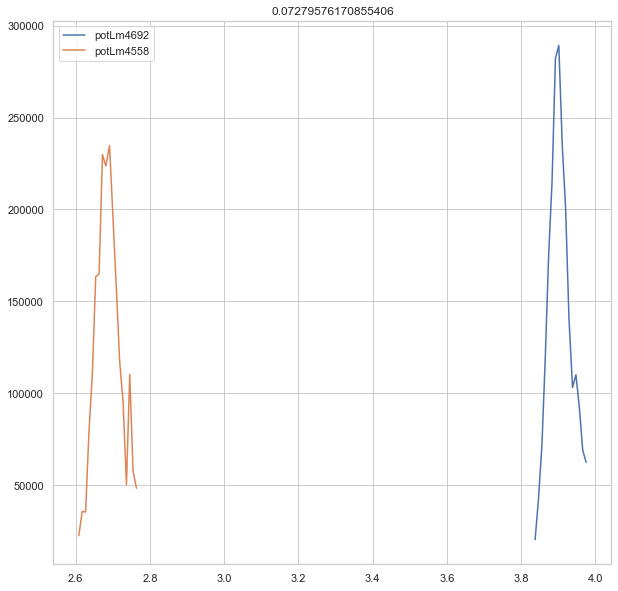

In [42]:
met1 = 'potLm4692' #573

met2= 'potLm4558'

plt.figure(figsize=(10,10))

try:
    label1 = dfAnnot.loc[met1[5:]][0]
except KeyError:
    label1 = met1

try:
    label2 = dfAnnot.loc[met2[5:]][0]
except KeyError:
    label2 = met2

#Returns random line from chromatograms
def random_line(fname):
    lines = open(fname).read().splitlines()
    randomNumber = random.randint(0, len(lines))
    print('RANDOMNUMBER: ' + str(randomNumber))
    #return lines[randomNumber], randomNumber
    return random.choice(lines)

#values1, randomNumber = random_line("chromatograms-tsv\\"+ met1 + '.tsv')
values1 = random_line("chromatograms-tsv\\"+ met1 + '.tsv')
values2 = random_line("chromatograms-tsv\\"+ met2 + '.tsv')


values1 = values1.split('\t')
values2 = values2.split('\t')

values1 = [float(i) for i in values1]
values2 = [float(i) for i in values2]

rt1 = values1[::2]
pi1 = values1[1::2]

rt2 = values2[::2]
pi2 = values2[1::2]
plt.title(scipy.stats.spearmanr(dfPANOL.loc[met1], dfPANOL.loc[met2])[0])


sns.lineplot(x = rt1, y= pi1, label = label1)
sns.lineplot(x= rt2, y = pi2, label = label2)
#plt.yscale('log')


dfHMDBPos.index = dfHMDBPos.index.map(str)
dfHMDBNeg.index = dfHMDBNeg.index.map(str)

try:
    print(str(met1) + ' ' + str(dfHMDBPos.loc[met1[5:]][3]))
except KeyError:
    print(str(met1) + ' ' + str(dfHMDBNeg.loc[met1[5:]][3]))

try:
    print(str(met2) + ' ' + str(dfHMDBPos.loc[met2[5:]][3]))
except KeyError:
    print(str(met2) + ' ' + str(dfHMDBNeg.loc[met2[5:]][3]))



#plt.savefig('Clust_68' + str(label1) + '_' + str(label2) +'ChromatogramPRESENT3')
#plt.savefig('potLm4692-DKFP_ChromatogramEx5')

**Looking at the scatterplot of correlated peaks**

Text(0, 0.5, 'potLm4558')

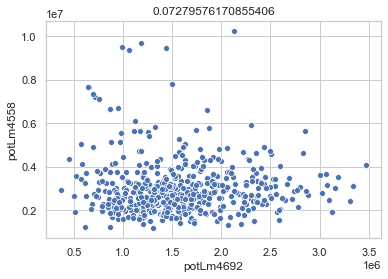

In [43]:
plt.title(scipy.stats.spearmanr(dfPANOL.loc[met1], dfPANOL.loc[met2])[0])
sns.scatterplot(dfPANOL.loc[met1], dfPANOL.loc[met2])
plt.xlabel(label1)
plt.ylabel(label2)
#plt.savefig('Clust_83' + str(label1) + '_' + str(label2) +'ScatterPRESENT')

**Look at all the masses in a cluster**

In [44]:
masses = []

dfHMDBPos.index = dfHMDBPos.index.map(str)
dfHMDBNeg.index = dfHMDBNeg.index.map(str)



for i in range(len(names)):
    try:
        masses += [[names[i], dfHMDBPos.loc[names[i][5:]][3]]]
    except KeyError:
        masses += [[names[i], dfHMDBNeg.loc[names[i][5:]][3]]]

masses.sort(key = lambda i : i[1])
masses

[['potLmfum-H', 115.003639999999],
 ['potLmsucc-H', 117.01933],
 ['potLm1695', 147.02981],
 ['potLmacnt-H', 173.00901],
 ['potLm1504', 174.0407],
 ['potLm4692', 243.026789999999],
 ['potLmamet+H', 399.14456]]

# Module 6 - Looking at MIDs from clusters

In [45]:
dfMC = dfMIDs.copy(deep = True)

clustNames = ['NAME']

for i in range(len(names)):
    try:
        clustNames += [pd.to_numeric(names[i][5:])]
        
    except ValueError:
        clustNames += [names[i][5:]]
        
dfMC = dfMC.loc[clustNames]

**Renaming all the columns so they match the peaks, eg from Unnamed --> Glucose**

In [46]:
#Create array where the indexes of the peaks are
array = []

for i in range(len(dfMC.columns)):
    if 'Unnamed' not in dfMC.columns[i]:
        array += [i]

#Renaming the columns
k = 0
rename = dfMC.columns[array[k]]
for j in range(8,len(dfMC.columns)):
    if 'Unnamed' not in dfMC.columns[j]:
        k += 1
        rename = dfMC.columns[array[k]]
        continue
    dfMC.rename(columns = {dfMC.columns[j]: rename}, inplace = True)
    

**Drop all columns that have sum = 0**

In [47]:
dropColumns = []
keepColumns = []


#C starts at column 7
for i in range(7,len(dfMC.columns)):
    if sum(dfMC.iloc[1:,i]) == 0: 
        dropColumns += [i]
    else:
        keepColumns += [i]
        #print('I is: ' + str(i))
 

**Create DataFrame of all columns that don't have sum = 0**

In [48]:
dfClustMID = pd.DataFrame()

for i in range(len(keepColumns)):
    name = str(dfMC.iloc[:,keepColumns[i]].name) +  ': ' + str(dfMC.iloc[:,keepColumns[i]].NAME)
    #print(name)
    dfClustMID[name] = dfMC.iloc[:,keepColumns[i]]
    


In [49]:
for i in range(1, len(dfClustMID.index)):
    try:
        dfClustMID.rename({dfClustMID.index[i] : z[str(dfClustMID.index[i])]}, inplace = True)
    except KeyError:
        continue

**Create dfHeat (used for heatmap below), same as dfClustMID but dropping the NAME-column**

In [50]:
dfHeat = dfClustMID.drop('NAME')

In [51]:
dfHeat

,Glucose: C1,Glucose: C2,Glucose: C3,Glucose: C4,Glucose: C5,Glucose: C6,Glutamine: C1,Glutamine: C2,Glutamine: C3,Glutamine: C4,...,Phenylalanine: C5,Glutamate: C2,Glutamate: C4,Glutamate: C5,Alanine: C2,Asparagine: C4,Serine: C2,Serine: C3,Serine: C4,Serine: C5
acetyl-aspartate,0,0.36155,0.083252,0.0750955,0.0239597,0,0.0213355,0.125977,0.0572591,0.307382,...,0.0243466,0.0118818,0.0196307,0,0.0206745,0.0102522,0,0,0,0
1695,0,0.0936688,0.0283882,0.0166255,0,0,0,0.0169067,0.0694018,0,...,0,0,0,0.0172874,0,0,0,0,0,0
aconitate,0,0.378615,0.104534,0.0994761,0.0657758,0,0.0418277,0.13326,0.0550752,0.255902,...,0,0,0,0,0.0152897,0.0110902,0,0,0,0
fumarate,0.0219229,0.126823,0.0898736,0.013029,0,0,0.0370216,0.100697,0.0358405,0.239608,...,0,0,0,0,0,0.0131061,0,0,0,0
succinate,0,0.0908866,0.0136306,0,0,0,0,0.0870065,0,0.16699,...,0,0,0,0,0,0,0,0,0,0
4692,0,0.0144071,0.0979019,0,0.0240395,0.539707,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
amet+H,0,0.114969,0.116018,0.0628226,0.218027,0.0293287,0,0,0,0,...,0,0,0,0,0,0,0.131618,0.10986,0.249229,0.0541333


**Check a specific peaks MID**

In [52]:
met = 1695
for i in range(len(dfHeat.loc[met])):
    if dfHeat.loc[met][i] != 0:
        print(dfHeat.loc[met][i], dfHeat.columns[i])

0.0936687585802852 Glucose: C2
0.0283881653803567 Glucose: C3
0.0166255241109309 Glucose: C4
0.0169066672010738 Glutamine: C2
0.0694017793612325 Glutamine: C3
0.171320499618482 Glutamine: C5
0.0172874066547689 Glutamate: C5


**Change df-values so that everything above 1 = 1, for more clear heatmap**

**Selected certain candidate, show only heatmap for the ones that have similar structure (not 0 in the columns where candidate are not 0)**

In [53]:
candidate = 1695
compare = dfHeat.loc[candidate]
save = [candidate]
for k in range(len(compare)):
    if compare[k] > 0:
        for i in range(len(dfHeat.index)):
            if dfHeat.index[i] == candidate:
                continue
            if dfHeat.iloc[i,k] > 0:
                if dfHeat.index[i] not in save:
                    save += [dfHeat.index[i]]
                else:
                    continue
        
                
dfCand = dfHeat.loc[save]

In [54]:
#Deleting columns where sum = 0
keepColumn = []
for i in range(len(dfCand.columns)):
    if sum(dfCand.iloc[:,i]) != 0:
        keepColumn += [i]
dfCand = dfCand[dfCand.columns[keepColumn]]

**Plotting heatmaps, both for all peaks and for the selected peaks + peaks with similar structures**

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

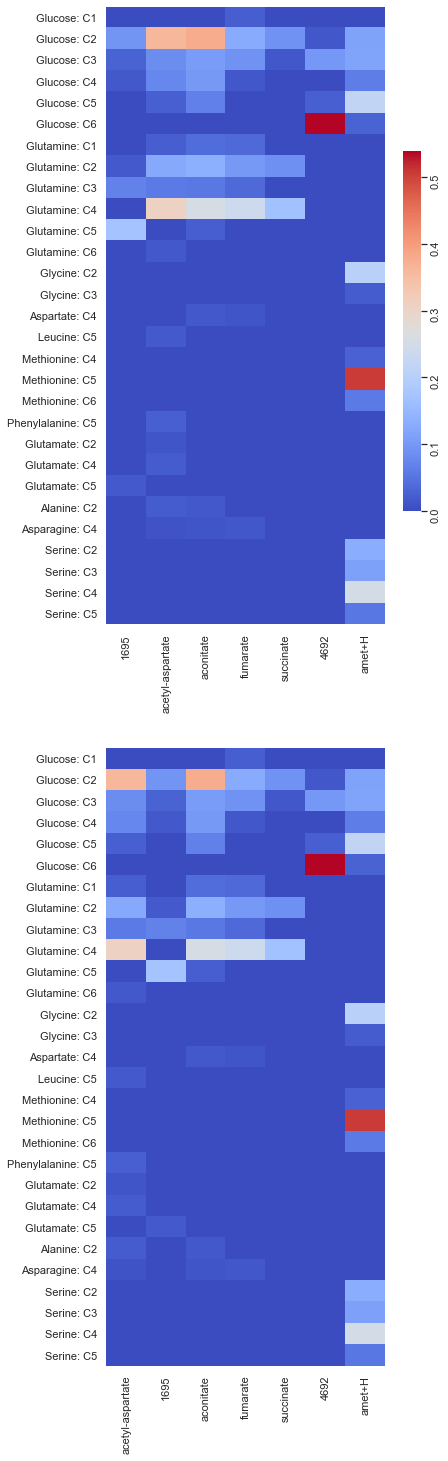

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(5,25))

cbar_ax = fig.add_axes([0.95, 0.6, 0.05, 0.2])

sns.set(font_scale=1)
sns.heatmap(dfCand.transpose().astype(float), cmap = 'coolwarm', ax = axs[0], yticklabels = True, cbar_ax = cbar_ax)
sns.heatmap(dfHeat.transpose().astype(float), cmap = 'coolwarm', ax = axs[1], yticklabels = True, cbar_ax = cbar_ax)
plt.yticks(rotation=90)

### Variables and DataFrames Explained:
- cvBio: All cv from metabolites with *postive* biovariance
- dfClusterPosBioVari: A dataframe extracted from dfPANOL with all positive biovariance, normalized with division by the mean and then logged (in that order). Outliers also removed, set to 2
- dfAnalyse: A df of metabolites with *positive* biovariance, with information about cvBio, cvQC, ratio cvBio/cvQC and cluster belongings

- dfPANOL = dfPeakAreasNoOverLaps, no overlapping metabolites
- dfPANOLWA = dfPANOL With Annotations from HMDB
- dfPANOLMin = Mean fold normalized df, outliers set to 4
- dfQCPeaks = QC peaks


# Module 7 - Checking Disease Associations

# Check Disease Associations
- dfDisFilt = filtered with only p-values under 0.05

In [57]:
filterP = dfDisease['pvalue'] <0.05
dfDisFilt = dfDisease[filterP]

In [58]:
dfDisFilt

,rLC peak Id,phenotype,pvalue,hr,hr_lower_CI,hr_upper_CI,beta,se,n_total,n_event
HMEC peak Id,,,,,,,,,,
5348,mtb_1769875,Asthma,0.012257,1.079165,1.016707,1.145461,0.076188,0.030418,7224,610
5348,mtb_1769875,CHD,0.033193,1.069867,1.005398,1.138469,0.067534,0.031710,7658,503
5348,mtb_1769875,COPD,0.004080,1.134911,1.041004,1.237290,0.126554,0.044067,7817,197
5348,mtb_1769875,stroke,0.036167,1.075027,1.004676,1.150304,0.072346,0.034532,7758,361
5348,mtb_3601661,MI,0.026237,0.868054,0.766226,0.983413,-0.141502,0.063662,7739,287
...,...,...,...,...,...,...,...,...,...,...
3855,mtb_1009534,liver,0.019444,0.797004,0.658894,0.964063,-0.226896,0.097092,7828,121
3855,mtb_1009534,MI,0.002520,0.828182,0.732836,0.935933,-0.188522,0.062405,7739,287
3855,mtb_1009534,T2D,0.004128,0.890474,0.822612,0.963933,-0.116002,0.040444,7568,656


In [59]:
dfDisease

,rLC peak Id,phenotype,pvalue,hr,hr_lower_CI,hr_upper_CI,beta,se,n_total,n_event
HMEC peak Id,,,,,,,,,,
5348,mtb_1769875,AD,0.474959,0.962551,0.866858,1.068806,-0.038169,0.053425,7875,261
5348,mtb_1769875,Asthma,0.012257,1.079165,1.016707,1.145461,0.076188,0.030418,7224,610
5348,mtb_1769875,autoimmune,0.820887,1.015820,0.886754,1.163672,0.015697,0.069330,7722,164
5348,mtb_1769875,cancer,0.604428,0.982095,0.917208,1.051573,-0.018067,0.034875,7612,715
5348,mtb_1769875,CHD,0.033193,1.069867,1.005398,1.138469,0.067534,0.031710,7658,503
...,...,...,...,...,...,...,...,...,...,...
3703,mtb_2673663,HF,0.530072,1.038224,0.923504,1.167195,0.037512,0.059742,4742,290
3703,mtb_2673663,liver,0.971266,1.004240,0.797743,1.264189,0.004231,0.117451,4816,72
3703,mtb_2673663,MI,0.798712,0.980313,0.841391,1.142173,-0.019883,0.077968,4763,178


# Module 8 - M/Z-RT Plots

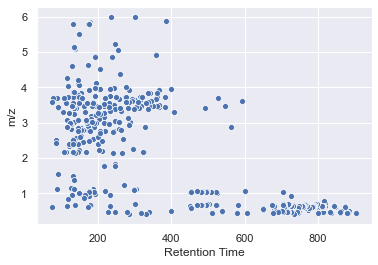

In [60]:
fig = plt.figure()
slineplot = sns.scatterplot(x = dfPeakList.iloc[:,1], y = dfPeakList.iloc[:,3])
plt.xlabel('Retention Time')
plt.ylabel('m/z')
fig = slineplot.get_figure()
#fig.savefig('rt_vs_mz_scatterplot', dpi = 800)

# Comparing mean value of peaks and runtimes (figure 6 in report) 

In [61]:
def plateRunMet(df, runtimes):
    
    quickdf = pd.DataFrame()
    
    
    plateMeans = []
    for i in range(len(runtimes.index)):
        mean = [df.loc[:,runtimes.iloc[i].name].mean()] #Taking plateName from runtimes and find the mean in dfPeakAreas
        plateMeans += mean

    meanArray = np.array(df.loc[:,runtimes.iloc[i].name].mean())#plateMeans
    runtimeArray = np.array(runtimes['Run time pos'])

    fig, ax = plt.subplots(2, figsize = (20,22))
    ax[0].plot(np.arange(len(runtimes)), runtimeArray)
    ax[0].set_ylabel('Runtime for each sample')
    ax[0].set_xlabel('Sample number')
    
    
    ax[1].plot(plateMeans)
    ax[1].set_ylabel('Mean of each sample', fontsize = 25)
    ax[1].set_xlabel('Sample number', fontsize = 25)
    #ax[1].set_xticklabels(fontsize = 20)
    
    bracketLines = [92, 188, 280, 366, 459]
    for xcord in bracketLines:
        #ax[1].axvline(x=xcord, color = 'red', alpha = 0.4)
        ax[1].axvline(x=xcord, color = 'red', alpha = 0.4)
    
    
    corr = scipy.stats.pearsonr(runtimeArray, plateMeans)[0] #runtimes.corr(meanArray, method = 'pearson')
    
    #fig.savefig('MeanvsRuntime', dpi=300) #Saving figure
    #print('Correlation value, ' + str('pearson') +': ' + str(corr)) 

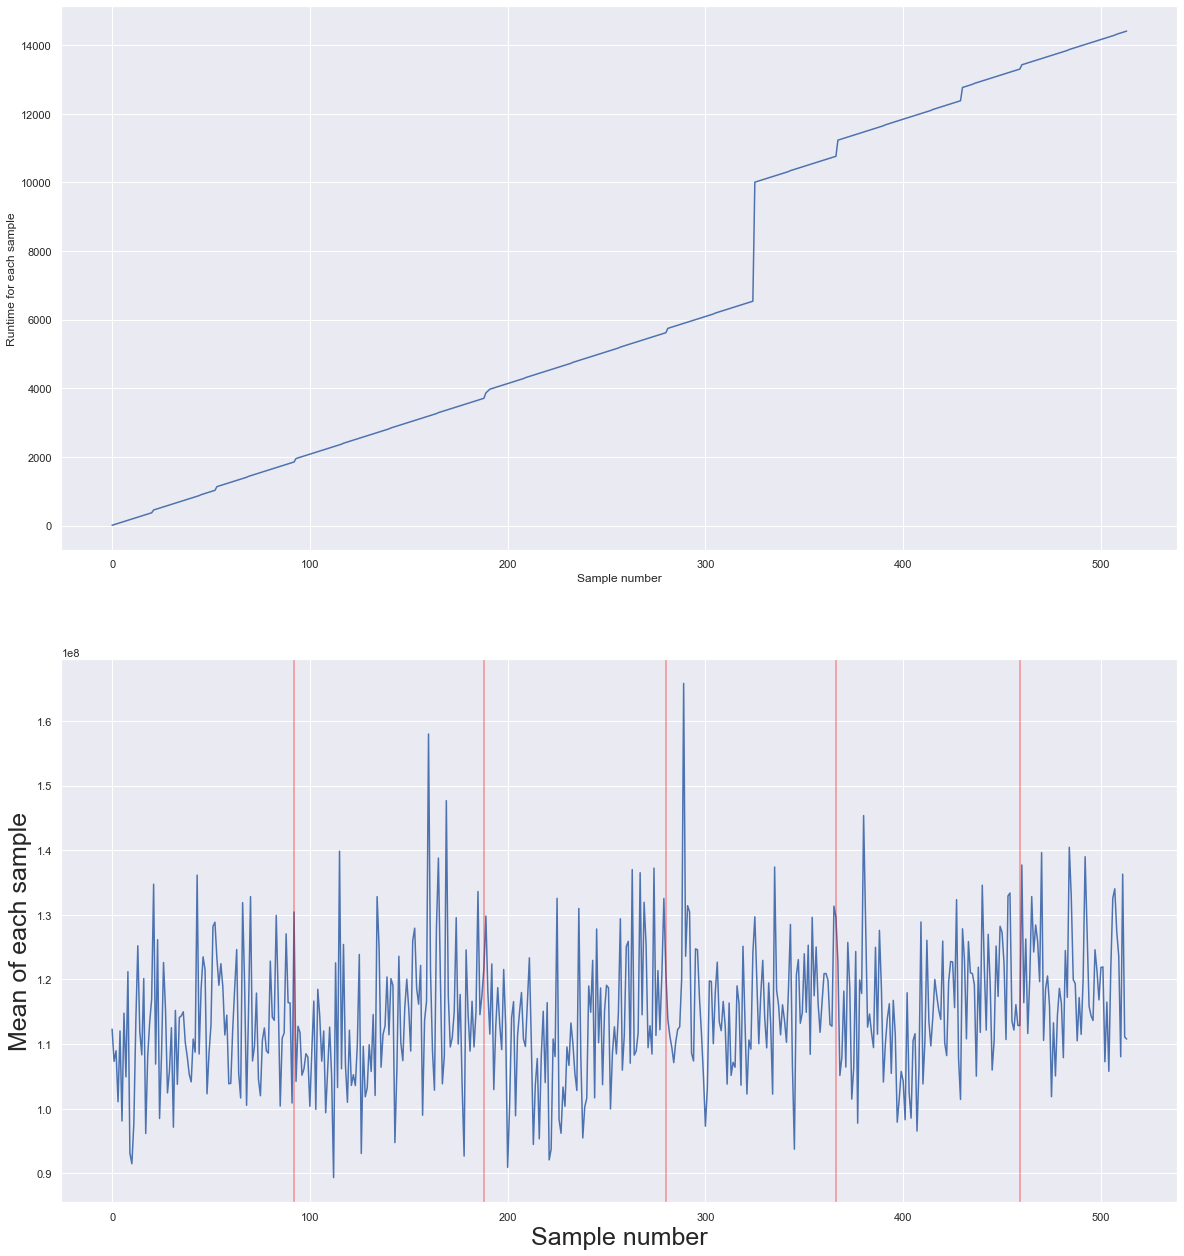

In [62]:
plateRunMet(dfPANOL, runtimes)

**Plotting estimated cvBio and observed cv (cvObs) (Figure 5 in report)**

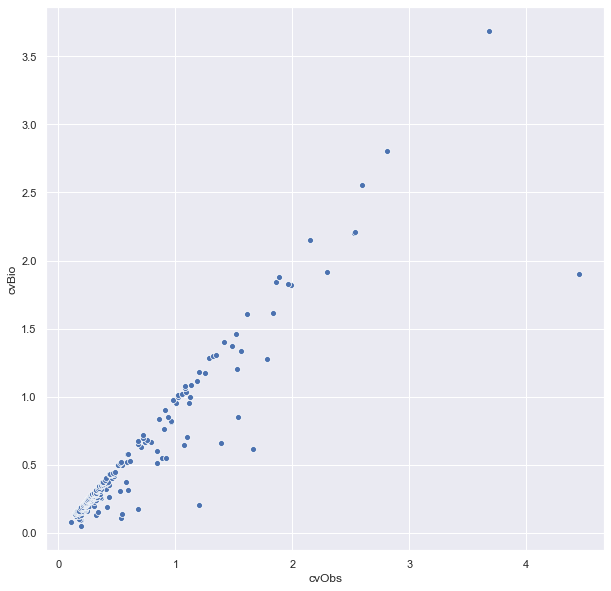

In [63]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = dfCV['cvObs'], y = dfCV['cvBio'])

# Module 9 : creating dfPANOL (file to import), random scatterplots

# Create a DataFrame with all overlapping peaks

In [64]:
def overlap(df):
    
    metCount = 0 #keeps track of how many peaks we found that were overlapping

    dfOverlap = pd.DataFrame()
    
    df = df.sort_values(by = [1])

    for i in range(len(df.index)):
        try: 
            if (df.iloc[i,1] > df.iloc[i+1,0]):
                if (((df.iloc[i,2] < df.iloc[i+1, 2]) & (df.iloc[i,3] > df.iloc[i+1, 2])) | 
                    ((df.iloc[i,2] < df.iloc[i+1, 3]) & (df.iloc[i,2] > df.iloc[i+1, 2])) |
                    ((df.iloc[i,2] < df.iloc[i+1, 2]) & (df.iloc[i,3] > df.iloc[i+1, 3])) |
                    ((df.iloc[i,2] > df.iloc[i+1, 2]) & (df.iloc[i,3] < df.iloc[i+1, 3]))):
                    if (df.iloc[i,4] == df.iloc[i+1,4]):
                        metCount = metCount + 1
                        dfOverlap = dfOverlap.append(df.iloc[i])
                        dfOverlap = dfOverlap.append(df.iloc[i+1])
        except IndexError:
            print('Done!')
        
    print(metCount)
    
    return dfOverlap

In [265]:
dfOverlap = overlap(dfPeakList)

Done!
47


In [26]:
#Save the overlap-datafarme
from pandas import ExcelWriter
writer = ExcelWriter('PythonExport.xlsx')
dfOverlap.to_excel(writer)
writer.save()

# Deleting overlaps

In [266]:
def deletingOverlaps(dfRTandMZ, dfPA):
    massCount = 0
  

    dfDeleteOverlap = pd.DataFrame()
    
    dfRTandMZ = dfRTandMZ.sort_values(by = [1]) 

    for i in range(len(dfRTandMZ.index)):
        try: 
            if (dfRTandMZ.iloc[i,1] > dfRTandMZ.iloc[i+1,0]):
                #Taking account to all possibilities for overlaps
                if (((dfRTandMZ.iloc[i,2] < dfRTandMZ.iloc[i+1, 2]) & (dfRTandMZ.iloc[i,3] > dfRTandMZ.iloc[i+1, 2])) | 
                    ((dfRTandMZ.iloc[i,2] < dfRTandMZ.iloc[i+1, 3]) & (dfRTandMZ.iloc[i,2] > dfRTandMZ.iloc[i+1, 2])) |
                    ((dfRTandMZ.iloc[i,2] < dfRTandMZ.iloc[i+1, 2]) & (dfRTandMZ.iloc[i,3] > dfRTandMZ.iloc[i+1, 3])) |
                    ((dfRTandMZ.iloc[i,2] > dfRTandMZ.iloc[i+1, 2]) & (dfRTandMZ.iloc[i,3] < dfRTandMZ.iloc[i+1, 3]))):
                    if (dfRTandMZ.iloc[i,4] == dfRTandMZ.iloc[i+1,4]):
                        massCount = massCount + 1
                        dfDeleteOverlap = dfOverlap.append(dfRTandMZ.iloc[i])
                        dfDeleteOverlap = dfDeleteOverlap.append(dfRTandMZ.iloc[i+1])
        except IndexError:
            print('Done!')
        
    print(massCount)
    
    return dfDeleteOverlap
            


In [267]:
#Returns a dataframe of all overlapping peaks, all duplicates
dfDeleteOverlaps = deletingOverlaps(dfPeakList, dfPeakAreas)

Done!
47


In [268]:
#Dropping duplicates with the same name, since above function sometimes included the same peaks twice
dfDeleteOverlaps.drop_duplicates(keep='first', inplace = True)

In [280]:
#Making a list of all those peaks to exclude from dataset
#Deleting those with the smaller of the PeakAreas
metNames = []

for i in range(len(dfDeleteOverlaps.index)-1):
    if (dfDeleteOverlaps.iloc[i][2] > dfDeleteOverlaps.iloc[i+1][1]):
        if (dfPeakAreas.loc[dfDeleteOverlaps.iloc[i].name].mean() < dfPeakAreas.loc[dfDeleteOverlaps.iloc[i+1].name].mean()):
            metNames.append(dfDeleteOverlaps.iloc[i].name)
        else:
            metNames.append(dfDeleteOverlaps.iloc[i+1].name)
        

In [220]:
#Deleting peaks from the dfPeakAreas
dfPeakAreasNoOL = dfPeakAreas.copy(deep=True)
for i in range(len(metNames)):
    for j in range(len(dfPeakAreasNoOL.index)):
        try:
            if (metNames[i] == dfPeakAreasNoOL.iloc[j].name):
                dfPeakAreasNoOL.drop(index = metNames[i],inplace = True)
        except IndexError:
            print(j)

449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403


**Save new DataFrame**

In [222]:
from pandas import ExcelWriter
writer = ExcelWriter('dfPeakAreasNoOL.xlsx')
dfPeakAreasNoOL.to_excel(writer)
writer.save()

# Create Random Scatterplots
**Plotting random peaks to get first feeling of peak intensities**

In [81]:
import random
def randomScatter(df, n):
    plt.figure(figsize = (8,8))
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1000,1000000000000)
    plt.xlim(1000,1000000000000)
    datax = np.empty(514,)
    datay = np.empty(514,)
    
    for i in range(0,n):
        rand1 = random.randint(0,449)
        rand2 = random.randint(0,449)
        
        sns.scatterplot(x= df.iloc[rand1,:], y=df.iloc[rand2,:], alpha = 0.5)
        #datax += df.iloc[rand1,:].values #Comment this if not mean
        #datay += df.iloc[rand2,:].values #Comment this if not mean
        
    #sns.scatterplot(x=datax/n, y = datay/n ) #Comment this if not mean
    plt.show()
    

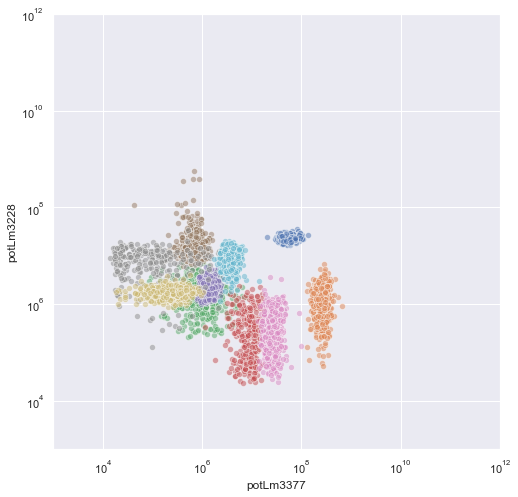

In [83]:
randomScatter(dfPANOL, 10)

# Figure 4 in project - plotting observed peaks vs QC

scatter makes plot of: potLm5824


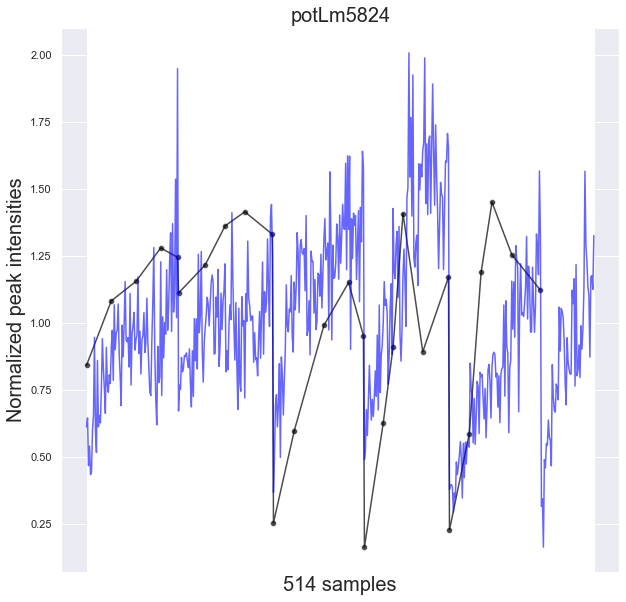

In [71]:
xBrackets = [0, 25, 50, 75, 92, 
             93, 120, 140, 160,  188, 
             189, 210, 240, 265, 280, 
             281, 300, 310, 320, 340, 366,
            367, 387, 399, 410, 430, 459]


name = 'potLm5824'
#value = dfNew.iloc[-1][0]

plt.figure(figsize = (10,10))
csfont = {'fontname':'Times New Roman'}



sns.scatterplot(y = dfQCPeaks.loc[name,:]/dfQCPeaks.loc[name].mean(), x = xBrackets, color = 'black', alpha = 0.7)
sns.lineplot(y = dfQCPeaks.loc[name,:]/dfQCPeaks.loc[name].mean(), x = xBrackets, color = 'black', alpha = 0.7)
print('scatter makes plot of: ' + str(name))
slineplot = sns.lineplot(data = dfPANOLNo0.loc[name, :]/dfPANOLNo0.loc[name].mean(), alpha=0.6, color = 'blue')


qcRSD = np.std(dfQCPeaks.loc[name,:])/dfQCPeaks.loc[name,:].mean()

plt.title(name, fontsize = 20) # +', CV: ' + str("%.2f" % value) + ' with a QC-CV of: ' + str("%.2f" %  qcRSD))
plt.ylabel ('Normalized peak intensities', fontsize = 20)
plt.xlabel ('514 samples', fontsize = 20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
fig = slineplot.get_figure()

#fig.savefig('Project_5824_QC_and_obs')#'Lineplot_Met_vs_QC_withRSD' + str(name), dpi = 800)



